In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import mlab
import json, ast
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from iso3166 import countries


import seaborn as sns
sns.set_style("whitegrid")

plt.style.use('classic')
%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

In [2]:
df_domains = pd.read_csv('data/domain.csv',sep=',', encoding='latin1', keep_default_na=False)
df_links = pd.read_csv('data/links.csv',sep='|', encoding='latin1', keep_default_na=False)

## Distribution of news websites using AMP

This is the distribution of AMP-enabled vs non AMP-enabled websites in Africa. Out of the 56 countries and territories surveyed in Africa, 40 (71.5%) have at least one of their news website running on AMP. Out of 1431 domains collected, 194 domains are AMP-enabled i.e. around 13.5%. This represents quite a significant level of popularity of the AMP platform on the continent. The countries with the highest number of AMP-enabled news websites are KE, ZM, NG and ZA. Figure below shows a distribution of AMP vs Non-AMP websites by country, where there is at least 2 AMP-enabled domains.


In [3]:
z = []
for index, row in df_domains.iterrows():
    z.append(len(df_links.loc[df_links.domain==row['domain']]))
df_domains['amp_links_count'] = z

/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


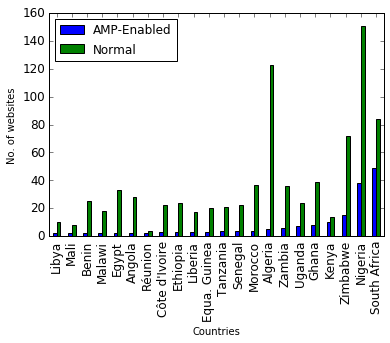

In [4]:
df1 = df_domains.iloc[:,[2,12]]
non_amp_domains = df1.loc[df1.amp_links_count == 0].groupby('cc').size()
amp_enabled_domains = df1.loc[df1.amp_links_count > 0].groupby('cc').size()

df2 = pd.DataFrame(columns=['cc','AMP-Enabled','Normal'])

for cc in df1['cc'].drop_duplicates():
    non_amp_size = 0
    amp_size = 0
    
    try:
        non_amp_size = non_amp_domains[cc]
        amp_size = amp_enabled_domains[cc]
    except KeyError:
        pass
    
    df2 = df2.append({'cc':cc, 'AMP-Enabled': amp_size, 'Normal':  non_amp_size}, ignore_index=True)
    
#df2['total'] = df2.apply(lambda row: row['AMP'] + row['Non-AMP'], axis=1)
#df2 = df2.iloc[:,[0,1,3]]

df2 = df2.loc[df2['AMP-Enabled']>1].sort_values(by='AMP-Enabled', ascending=True)

df2['cc_name'] = df2.apply(lambda x: countries.get(x.cc).name, axis=1)
df2.set_value(38, 'cc_name', 'Tanzania')
df2.set_value(16, 'cc_name', 'Equa. Guinea')

ax = df2.plot.bar(stacked=False, figsize=(6,4), x='cc_name', rot=90, fontsize=10)
plt.ylabel('No. of websites')
#plt.grid(True)
#plt.title("Distribution of AMP vs non-AMP websites by country", fontsize=10)
plt.xlabel('Countries')
plt.xticks(size = 12)
plt.yticks(size = 12) 
plt.savefig("data/plots/distribution_website_amp_vs_nonamp.pdf", bbox_inches = 'tight')
plt.show()

In [5]:
len(df2.cc_name.drop_duplicates())

22

# Web QoE analysis

In [21]:
df_ori_amp_results = pd.read_csv('data/ori_amp_url_results.csv', sep=';', encoding='utf-8', 
                                 keep_default_na=False, 
                                 converters={'InitialConnection':int, 'DNSLookupTime':int})
df_ori_amp_results = df_ori_amp_results[(df_ori_amp_results.HTTPStatus == '200')
                                        & (df_ori_amp_results.StatusText == 'OK')
#                                         & (df_ori_amp_results['InitialConnection'] > 0)
#                                         & (df_ori_amp_results['DNSLookupTime'] > 0)
#                                         & (df_ori_amp_results['TotalDownloadedBytes'] < 15000000)
                                       ] #outliers



df_1 = pd.read_csv('data/amp_viewer_url_results-1307201.csv', sep=';', encoding='utf-8', keep_default_na=False)
df_2 = pd.read_csv('data/amp_viewer_url_results-1707201.csv', sep=';', encoding='utf-8', keep_default_na=False)
df_3 = pd.read_csv('data/amp_viewer_url_results-2307201.csv', sep=';', encoding='utf-8', keep_default_na=False)
df_4 = pd.read_csv('data/amp_viewer_url_results-21092018.csv', sep=';', encoding='utf-8', keep_default_na=False)


df_amp_viewer_results = pd.concat([df_1, df_2, df_3, df_4])

# df_amp_viewer_results = pd.read_csv('data/amp_viewer_url_results-1707201.csv', sep=';', encoding='utf-8', 
#                                      keep_default_na=False,
#                                     converters={'TotalDownloadedBytes':int}
#                                    )                                  
df_amp_viewer_results = df_amp_viewer_results[(df_amp_viewer_results.HTTPStatus == 200)
                                              & (df_amp_viewer_results.StatusText == 'OK')
                                               & (df_amp_viewer_results['PageLoadTime'] > 0)
                                               & (df_amp_viewer_results['TotalDownloadedBytes'] > 1020) 
                                             ]

df_amp_cdn_results = pd.read_csv('data/amp_cdn_url_results21092018.csv', sep=';', encoding='utf-8', 
                                 keep_default_na=False,
                                 converters={'HTTPStatus':str, 'InitialConnection':int, 'DNSLookupTime':int})
df_amp_cdn_results = df_amp_cdn_results[(df_amp_cdn_results.HTTPStatus == '200') & 
                                        (df_amp_cdn_results.StatusText == 'OK') & 
                                        (df_amp_cdn_results.InitialConnection > 0) &
                                        (df_amp_cdn_results.DNSLookupTime > 0) &
                                        (df_amp_cdn_results['TotalDownloadedBytes'] > 1020) 
                                       ]

df_url_results = pd.read_csv('data/url_results.csv', sep=';', encoding='utf-8',
                             keep_default_na=False,
                            converters={'InitialConnection':int, 'DNSLookupTime':int})
df_url_results = df_url_results[(df_url_results.HTTPStatus == 200) 
                                & (df_url_results.StatusText == 'OK')
#                                 & (df_url_results['InitialConnection'] > 0)
#                                 & (df_url_results['DNSLookupTime'] > 0)
#                                 & (df_url_results['PageLoadTime'] > 0)
#                                 & (df_url_results['TotalDownloadedBytes'] < 15000000)
                               ]

# #bytes into MB
df_ori_amp_results['TotalDownloadedBytes'] = df_ori_amp_results.apply(lambda x: int(x['TotalDownloadedBytes'])/1000000, axis=1)
df_amp_viewer_results['TotalDownloadedBytes'] = df_amp_viewer_results.apply(lambda x: int(x['TotalDownloadedBytes'])/1000000, axis=1)
df_amp_cdn_results['TotalDownloadedBytes'] = df_amp_cdn_results.apply(lambda x: x['TotalDownloadedBytes']/1000000, axis=1)
df_url_results['TotalDownloadedBytes'] = df_url_results.apply(lambda x: int(x['TotalDownloadedBytes']/1000000), axis=1)

df_size1 = df_url_results.iloc[:,[1,6,9,11,12,13,14]]
df_size1 = df_size1.assign(Type='Web URL')

df_size2 = df_ori_amp_results.iloc[:,[1,6,9,11,12,13,14]]
df_size2 = df_size2.assign(Type='AMP URL')

df_size3 = df_amp_viewer_results.iloc[:,[1,6,9,11,12,13,14]]
df_size3 = df_size3.assign(Type='AMP Viewer URL')

df_size4 = df_amp_cdn_results.iloc[:,[1,6,9,11,12,13,14]]
df_size4 = df_size4.assign(Type='AMP CDN URL')

df_sizes = pd.concat([df_size1, df_size2, df_size3, df_size4])
#df_sizes = pd.concat([df_size1, df_size2, df_size3])

## CDFs
### TotalDownloadedBytes


### All in one

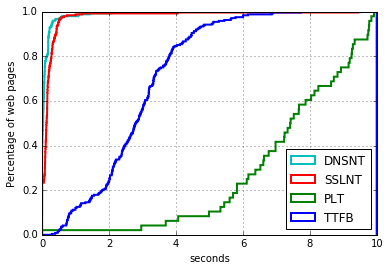

In [22]:
n_bins = 5000

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
fig, ax1 = plt.subplots(figsize=(6, 4))

labels = ['TTFB', 'PLT', 'SSLNT', 'DNSNT']

linestyles = ['solid','dashed']
#plot the cumulative histogram
n, bins, patches = ax1.hist([df_size1['TTFB'].values/1000, 
                            df_size1['PageLoadTime'].values/1000, 
                            df_size1['SSLNegotiationTime'].values/1000,
                            df_size1['DNSLookupTime'].values/1000
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, 
                            range=[0,10],
                           cumulative=True, label=labels)
                                    
# tidy up the figure
ax1.grid(True)
ax1.legend(loc='lower right')
#ax1.set_title('Web URL')
ax1.set_xlabel('seconds')
ax1.set_ylabel('Percentage of web pages')

plt.savefig("data/plots/CDF_WebURL_allinone.pdf")
plt.show()

##### TotalDownloadedBytes

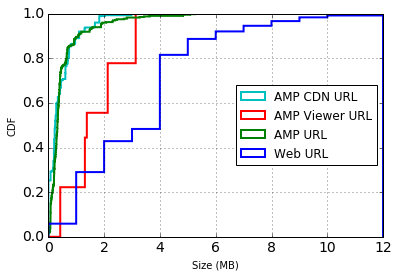

In [23]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL', 'AMP CDN URL']

#plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['TotalDownloadedBytes'].values, 
                            df_size2['TotalDownloadedBytes'].values,
                            df_size3['TotalDownloadedBytes'].values,
                            df_size4['TotalDownloadedBytes'].values
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,12],
                           cumulative=True, label=labels)
                                    
# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('Page Size by URL Type')
ax.set_xlabel('Size (MB)')
ax.set_ylabel('CDF')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.savefig("data/plots/CDF_TotalDownloadedBytes.pdf", bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

### PageLoadTime


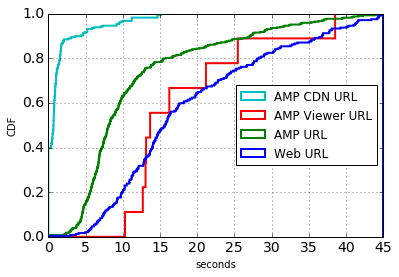

In [24]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL', 'AMP CDN URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['PageLoadTime'].values/1000, 
                            df_size2['PageLoadTime'].values/1000,
                            df_size3['PageLoadTime'].astype(np.int)/1000,
                            df_size4['PageLoadTime'].astype(np.int)/1000
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, 
                           range=[0,45],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('Page Load Time by URL Type')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.savefig("data/plots/CDF_PageLoadTime.pdf",bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

### TTFB


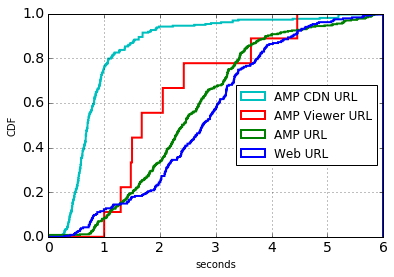

In [25]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL', 'AMP CDN URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['TTFB']/1000, 
                            df_size2['TTFB']/1000,
                            df_size3['TTFB'].astype(np.int)/1000,
                            df_size4['TTFB'].astype(np.int)/1000
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,6],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('TTFB by URL Type')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.savefig("data/plots/CDF_TTFB.pdf",bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

### SSLNegotiationTime


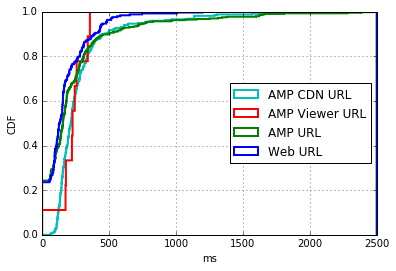

In [18]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL', 'AMP CDN URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['SSLNegotiationTime'], 
                            df_size2['SSLNegotiationTime'],
                            df_size3['SSLNegotiationTime'].astype(np.int),
                            df_size4['SSLNegotiationTime'].astype(np.int)
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2500],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('SSLNegotiationTime by URL Type')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_SSLNegotiationTime.pdf")
plt.show()

### DNSLookupTime


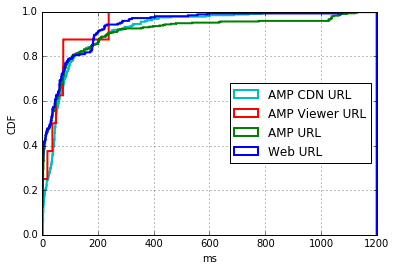

In [19]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL', 'AMP CDN URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['DNSLookupTime'], 
                            df_size2['DNSLookupTime'],
                            df_size3['DNSLookupTime'].astype(np.int),
                            df_size4['DNSLookupTime'].astype(np.int)
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1200],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('DNSLookupTime by URL Type')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_DNSLookupTime.pdf")
plt.show()

### InitialConnection


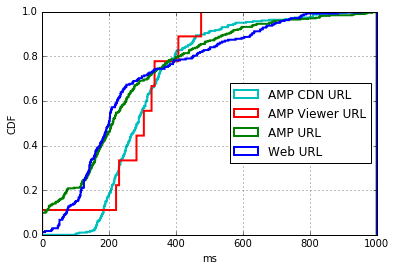

In [20]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Web URL', 'AMP URL', 'AMP Viewer URL', 'AMP CDN URL']

# plot the cumulative histogram
n, bins, patches = ax.hist([df_size1['InitialConnection'], 
                            df_size2['InitialConnection'],
                            df_size3['InitialConnection'],
                            df_size4['InitialConnection']
                           ], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label=labels)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('InitialConnection by URL Type')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_InitialConnection.pdf")
plt.show()

## QoE EU/US vs Africa

In [148]:
def f(cc):
    if (cc in ["FR", "GB", "NL", "DE"]):
        return "EU"
    else:
        return "US"

df_url_results_euus = pd.read_csv('data/url_results_EUUS16072018.csv', sep=';', encoding='latin1',
                             keep_default_na=False)
df_url_results_euus = df_url_results_euus[(df_url_results_euus.HTTPStatus == '200') & 
                                 (df_url_results_euus.StatusText == 'OK') &
                                 (df_url_results_euus.PageLoadTime > 0)        
                            ]

df_amp_viewer_url_results_euus = pd.read_csv('data/amp_viewer_url_results_EUUS21072018.csv', sep=';', encoding='latin1',
                             keep_default_na=False)
df_amp_viewer_url_results_euus = df_amp_viewer_url_results_euus[(df_amp_viewer_url_results_euus.HTTPStatus == '200') & 
                                 (df_amp_viewer_url_results_euus.StatusText == 'OK') &
                                 (df_amp_viewer_url_results_euus.PageLoadTime > 0)]  


df_url_results_euus['probe_cc'] = df_url_results_euus.apply(lambda x: ast.literal_eval(x.ProbeInfo)['CountryCode'], axis = 1)
# df_url_results_euus['platform'] = df_url_results_euus.apply(lambda x: ast.literal_eval(x.ProbeInfo)['Platform'], axis = 1)
df_amp_viewer_url_results_euus['probe_cc'] = df_amp_viewer_url_results_euus.apply(lambda x: ast.literal_eval(x.ProbeInfo)['CountryCode'], axis = 1)
df_amp_viewer_url_results_euus['TotalDownloadedBytes'] = df_amp_viewer_url_results_euus.apply(lambda x: int(x['TotalDownloadedBytes'])/1000000, axis=1)
df_url_results_euus['TotalDownloadedBytes'] = df_url_results_euus.apply(lambda x: int(x['TotalDownloadedBytes'])/1000000, axis=1)


                                                                
df_url_results_euus['region'] = df_url_results_euus.apply(lambda x: f(x['probe_cc']), axis=1)
df_amp_viewer_url_results_euus['region'] = df_amp_viewer_url_results_euus.apply(lambda x: f(x['probe_cc']), axis=1)



### Web URL PageLoadTime EUUS vs AF

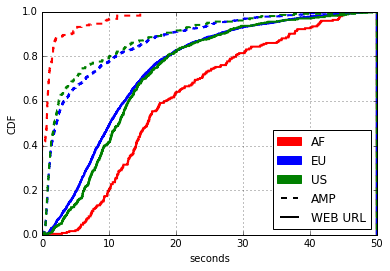

In [152]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['PageLoadTime']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['PageLoadTime']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['PageLoadTime']

df_amp_af = df_size4['PageLoadTime']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['PageLoadTime']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['PageLoadTime']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,50],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
#ax.set_title('Page Load Time')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')

red_patch = mpatches.Patch(color='red', label='AF')
blue_patch = mpatches.Patch(color='blue', label='EU')
green_patch = mpatches.Patch(color='green', label='US')
amp_line = mlines.Line2D([], [], color='black', linestyle="--", linewidth=2, markersize=15, label='AMP')
url_line = mlines.Line2D([], [], color='black', markersize=15,linewidth=2,  label='WEB URL')
plt.legend(handles=[red_patch, blue_patch, green_patch, amp_line, url_line], loc="lower right")

plt.savefig("data/plots/CDF_PLT_EU-US-AF.pdf")
plt.show()

### DNSLookupTime

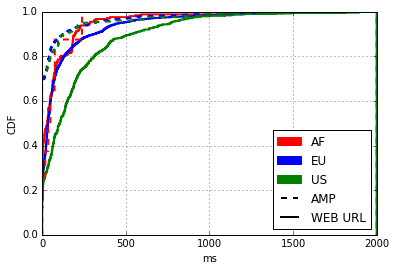

In [150]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['DNSLookupTime']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['DNSLookupTime']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['DNSLookupTime']

df_amp_af = df_size3['DNSLookupTime']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['DNSLookupTime']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['DNSLookupTime']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,2000],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
#ax.set_title('DNS Lookup Time')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

red_patch = mpatches.Patch(color='red', label='AF')
blue_patch = mpatches.Patch(color='blue', label='EU')
green_patch = mpatches.Patch(color='green', label='US')
amp_line = mlines.Line2D([], [], color='black', linestyle="--", linewidth=2, markersize=15, label='AMP')
url_line = mlines.Line2D([], [], color='black', markersize=15,linewidth=2,  label='WEB URL')
plt.legend(handles=[red_patch, blue_patch, green_patch, amp_line, url_line], loc="lower right")

plt.savefig("data/plots/CDF_DNS_EU-US-AF.pdf")
plt.show()

### SSLNegotiationTime

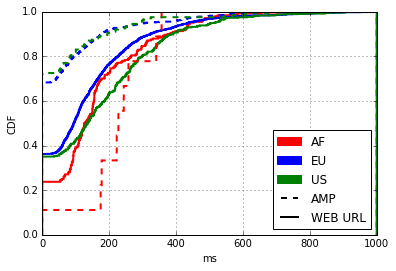

In [66]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['SSLNegotiationTime']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['SSLNegotiationTime']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['SSLNegotiationTime']

df_amp_af = df_size3['SSLNegotiationTime']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['SSLNegotiationTime']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['SSLNegotiationTime']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,1000],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
#ax.set_title('SSL Negotiation Time')
ax.set_xlabel('ms')
ax.set_ylabel('CDF')

red_patch = mpatches.Patch(color='red', label='AF')
blue_patch = mpatches.Patch(color='blue', label='EU')
green_patch = mpatches.Patch(color='green', label='US')
amp_line = mlines.Line2D([], [], color='black', linestyle="--", linewidth=2, markersize=15, label='AMP')
url_line = mlines.Line2D([], [], color='black', markersize=15,linewidth=2,  label='WEB URL')
plt.legend(handles=[red_patch, blue_patch, green_patch, amp_line, url_line], loc="lower right")

plt.savefig("data/plots/CDF_SSL_EU-US-AF.pdf")
plt.show()

### TTFB

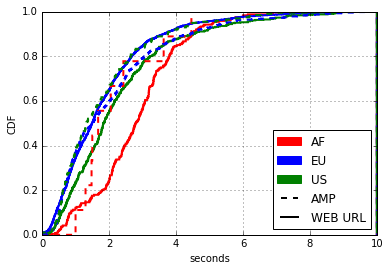

In [67]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['TTFB']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['TTFB']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['TTFB']

df_amp_af = df_size3['TTFB']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['TTFB']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['TTFB']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)/1000], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('TTFB')
ax.set_xlabel('seconds')
ax.set_ylabel('CDF')

red_patch = mpatches.Patch(color='red', label='AF')
blue_patch = mpatches.Patch(color='blue', label='EU')
green_patch = mpatches.Patch(color='green', label='US')
amp_line = mlines.Line2D([], [], color='black', linestyle="--", linewidth=2, markersize=15, label='AMP')
url_line = mlines.Line2D([], [], color='black', markersize=15,linewidth=2,  label='WEB URL')
plt.legend(handles=[red_patch, blue_patch, green_patch, amp_line, url_line], loc="lower right")

plt.savefig("data/plots/CDF_TTFB_EU-US-AF.pdf")
plt.show()

### Page size EUUS vs AF, AMP Viewer vs normal

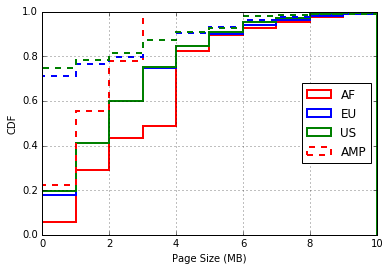

In [677]:
n_bins = 500

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['AF', 'EU', 'US']

df_af = df_size1['TotalDownloadedBytes']
df_eu = df_url_results_euus.loc[df_url_results_euus.region=='EU']['TotalDownloadedBytes']
df_us = df_url_results_euus.loc[df_url_results_euus.region=='US']['TotalDownloadedBytes']

df_amp_af = df_size3['TotalDownloadedBytes']
df_amp_eu = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='EU']['TotalDownloadedBytes']
df_amp_us = df_amp_viewer_url_results_euus.loc[df_amp_viewer_url_results_euus.region=='US']['TotalDownloadedBytes']

#bp = ax.boxplot(df_eu.astype(np.int), notch=0, sym='+', vert=1, whis=1.5)


# plot the cumulative histogram
n, bins, patches = ax.hist([df_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='AF', color='red')
n, bins, patches = ax.hist([df_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='EU', color='blue')
n, bins, patches = ax.hist([df_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, label='US', color='green')

n, bins, patches = ax.hist([df_amp_af.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='red', label="AMP")
n, bins, patches = ax.hist([df_amp_eu.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='blue')
n, bins, patches = ax.hist([df_amp_us.astype(np.int)], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,10],
                           cumulative=True, linestyle="--", color='green')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('TTFB')
ax.set_xlabel('Page Size (MB)')
ax.set_ylabel('CDF')

plt.savefig("data/plots/CDF_PAGE_SIZE_AMP_EUUS.pdf")
plt.show()

### Lab experiment

In [594]:
df_lab = pd.read_csv('data/all_load_times.csv',sep=',', encoding='latin1', keep_default_na=False,
                    converters={'carousel':int, 'google-search':int})


In [595]:
df_carousel = df_lab.iloc[:,[0,1,5]]
df_carousel = df_carousel.assign(Type='Carousel')
df_carousel = df_carousel.rename({'website':'Website',
                                       'carousel':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_search = df_lab.iloc[:,[0,2,5]]
df_search = df_search.assign(Type='Google Search')
df_search = df_search.rename({'website':'Website',
                                       'google-search':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_mobile = df_lab.iloc[:,[0,3,5]]
df_mobile = df_mobile.assign(Type='Web URL')
df_mobile = df_mobile.rename({'website':'Website',
                                       'mobile':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_amp = df_lab.iloc[:,[0,4,5]]
df_amp = df_amp.assign(Type='AMP URL')
df_amp = df_amp.rename({'website':'Website',
                                       'original-amp':'LoadTime',
                                       'country':'Country','Type':'Type'}, axis=1)

df_lab2 = pd.concat([df_carousel, df_search, df_mobile, df_amp], sort=True)

df_lab2



,Country,LoadTime,Type,Website,mobile-site
0,UK,1782.0,Carousel,punchng,NaN
1,UK,2716.0,Carousel,dailypost,NaN
2,UK,3269.0,Carousel,dailypost,NaN
3,UK,2281.0,Carousel,dailypost,NaN
4,UK,3170.0,Carousel,punchng,NaN
5,UK,2308.0,Carousel,punchng,NaN
6,UK,2754.0,Carousel,punchng,NaN
7,UK,4277.0,Carousel,punchng,NaN
8,UK,3877.0,Carousel,dailypost,NaN
9,UK,1415.0,Carousel,dailypost,NaN


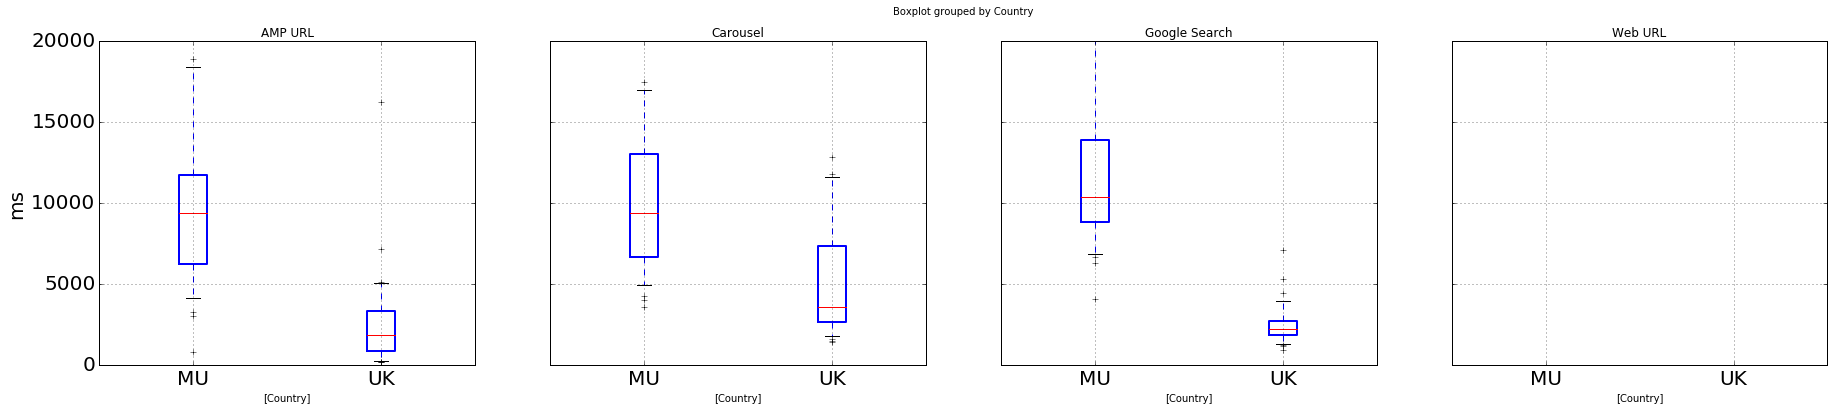

In [596]:
axes = df_lab2.groupby('Type').boxplot(column='LoadTime', 
                                       by=['Country'], figsize=(30,6), 
                                       layout=(1,4), whis=[5,95], 
                                       boxprops=boxprops,
                                       fontsize=20)

for ax in axes.values:
    ax.set_ylim(0, 20000)
    ax.set_ylabel("ms", fontsize=20)

plt.savefig("data/plots/boxplot_lab.pdf")
plt.show()

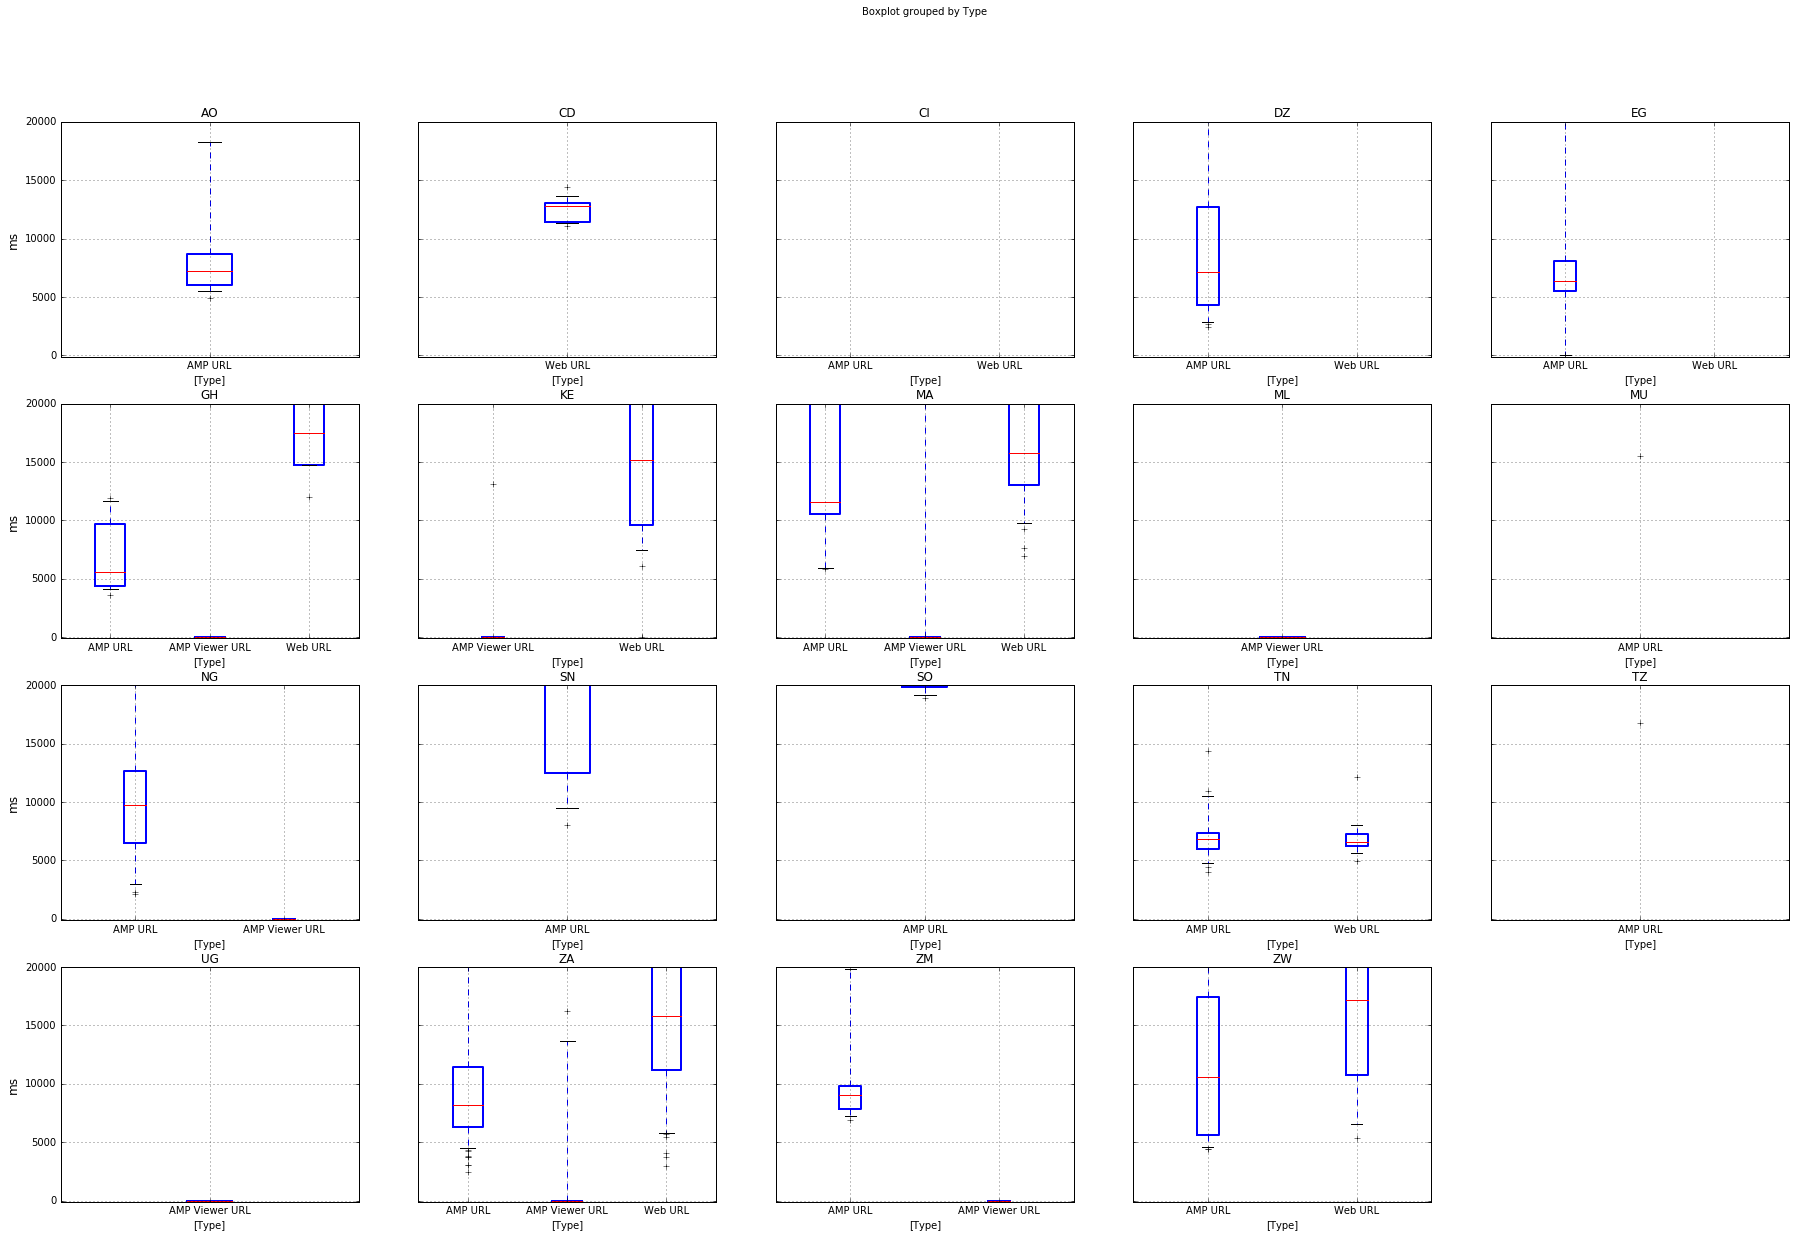

In [597]:
axes = df_sizes.groupby('cc').boxplot(column='PageLoadTime', by=['Type'], figsize=(30,20), layout=(4,5), whis=[5,95], boxprops=boxprops)

for ax in axes.values:
    ax.set_ylim(-100, 20000)
    ax.set_ylabel("ms", fontsize=12)

plt.savefig("data/plots/boxplot_PageLoadTime.pdf")
plt.show()

In [626]:
df_sizes.loc[(df_sizes.Type=='AMP Viewer URL') & (df_sizes.PageLoadTime > 0)]

,cc,DNSLookupTime,InitialConnection,PageLoadTime,SSLNegotiationTime,TTFB,TotalDownloadedBytes,Type
21,ZA,76,475,13686,357,1500,1.312266,AMP Viewer URL
22,ZA,239,407,16270,341,1674,1.312266,AMP Viewer URL
84,ZA,2758,221,12699,175,4461,0.428665,AMP Viewer URL
85,ZA,75,327,10309,244,2428,0.428665,AMP Viewer URL
167,KE,0,0,13144,0,1001,1.380097,AMP Viewer URL
305,MA,19,282,21190,228,3632,2.130026,AMP Viewer URL
306,MA,3,230,38554,178,2053,2.130026,AMP Viewer URL
322,MA,50,336,25472,258,1479,3.134004,AMP Viewer URL
330,MA,37,304,13069,223,1298,3.134004,AMP Viewer URL


In [134]:
df_traces = pd.read_json("data/RIPE-Atlas-measurement-16236437.json")

In [135]:
df_traces = df_traces.loc[df_traces.dst_addr.notnull()]
df_traces = df_traces.dropna()

In [142]:
def getMinRTT(rtts):
    if(len(rtts) > 0):
        last_hop = rtts[len(rtts)-1]
        last_hop_rtt = last_hop['result']
        #last_hop_rtt[0]['rtt']
        rtt_array = []
        for r in last_hop_rtt:
            try:
                rtt_array.append(r['rtt'])
            except:
                continue
        return pd.Series(rtt_array).min()
    else:
        return None

In [ ]:
df_traces

In [140]:
df_traces.drop(df_traces.index[333], inplace=True)

In [143]:
df_traces['rtt'] = df_traces.apply(lambda x: getMinRTT(x['result']), axis=1)

array([[4, '216.58.223.65', 'cdn.ampproject.org', ..., 162.227155,
        'traceroute', 31.34],
       [4, '216.58.223.97', 'cdn.ampproject.org', ..., 1.020545,
        'traceroute', 0.468],
       [4, '74.125.133.132', 'cdn.ampproject.org', ..., 220.302175,
        'traceroute', 247.16],
       ...,
       [4, '172.217.23.161', 'cdn.ampproject.org', ..., 5598.777185,
        'traceroute', 116.712],
       [4, '216.58.223.97', 'cdn.ampproject.org', ..., 25.78538,
        'traceroute', 65.69],
       [4, '216.58.223.65', 'cdn.ampproject.org', ..., 54.462785,
        'traceroute', 94.364]], dtype=object)